# 타이타닉 생존 예측

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

# data import
titanic = sns.load_dataset('titanic')[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'survived']]
display(titanic.head())
display(titanic.info())

,pclass,sex,age,sibsp,parch,fare,survived
0,3,male,22.0,1,0,7.2500,0
1,1,female,38.0,1,0,71.2833,1
2,3,female,26.0,0,0,7.9250,1
3,1,female,35.0,1,0,53.1000,1
4,3,male,35.0,0,0,8.0500,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    891 non-null    int64  
 1   sex       891 non-null    object 
 2   age       714 non-null    float64
 3   sibsp     891 non-null    int64  
 4   parch     891 non-null    int64  
 5   fare      891 non-null    float64
 6   survived  891 non-null    int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 48.9+ KB


None

## 데이터 전처리

### Object 제거 - OneHotEncoder

In [17]:
# get_dummies 이용
titanic_encoded = pd.get_dummies(titanic, columns=['sex'])
display(titanic_encoded.head())

,pclass,age,sibsp,parch,fare,survived,sex_female,sex_male
0,3,22.0,1,0,7.2500,0,False,True
1,1,38.0,1,0,71.2833,1,True,False
2,3,26.0,0,0,7.9250,1,True,False
3,1,35.0,1,0,53.1000,1,True,False
4,3,35.0,0,0,8.0500,0,False,True


In [ ]:
# from sklearn.preprocessing import OneHotEncoder

# encoder = OneHotEncoder(sparse_output=False)
# encoded = encoder.fit_transform(titanic[['sex']])
# encoded_titanic = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['sex']))

# titanic_encoded = pd.concat([titanic.drop(columns=['sex']), encoded_titanic], axis=1)
# titanic_encoded.head()

,pclass,age,sibsp,parch,fare,survived,sex_female,sex_male
0,3,22.0,1,0,7.2500,0,0.0,1.0
1,1,38.0,1,0,71.2833,1,1.0,0.0
2,3,26.0,0,0,7.9250,1,1.0,0.0
3,1,35.0,1,0,53.1000,1,1.0,0.0
4,3,35.0,0,0,8.0500,0,0.0,1.0


### age 결측치 채우기 - IterativeImputer

In [18]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(random_state=42, max_iter=10)
titanic_noempty = titanic_encoded.copy()
titanic_noempty['age'] = imputer.fit_transform(titanic_encoded)

### age 결측치 채우기 - KNN 회귀

In [4]:
# idx = titanic_encoded['age'].isna()

# X_full = titanic_encoded[['survived', 'pclass', 'sibsp', 'parch', 'fare', 'sex_female', 'sex_male']][~idx].to_numpy()
# X_empty = titanic_encoded[['survived', 'pclass', 'sibsp', 'parch', 'fare', 'sex_female', 'sex_male']][idx].to_numpy()
# y_full = titanic_encoded['age'][~idx].to_numpy()
# y_empty = titanic_encoded['age'][idx].to_numpy()

# from sklearn.neighbors import KNeighborsRegressor

# X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, random_state=42)

# ss = StandardScaler()
# X_train = ss.fit_transform(X_train)
# X_test = ss.transform(X_test)

# n_neighbors = range(1, 30, 2)
# knr_scores = []

# for k in n_neighbors:
#     knr = KNeighborsRegressor(n_neighbors=k)
#     knr.fit(X_train, y_train)
#     knr_train = knr.score(X_train, y_train)
#     knr_test = knr.score(X_test, y_test)
#     knr_scores.append((k, knr_test, knr_train))

# max_k, max_knr_test, max_knr_train = max(knr_scores, key=lambda x:x[1])

# print(f'=== KNN Regressor(best k={max_k}) ===')
# print('Train score:', max_knr_train)
# print('Test score :', max_knr_test)

# knr = KNeighborsRegressor(n_neighbors=max_k)
# knr.fit(X_train, y_train)
# pass

In [5]:
# titanic_noempty = titanic_encoded.copy()
# titanic_noempty['age'][idx] = knr.predict(X_empty)

### fare 이상치 제거 - 중앙값

In [19]:
def detect_outliers_by_group(data: pd.DataFrame, group_col: str, value_col: str):
    """그룹별 이상치 탐지"""
    # 우선 전원 모두 이상치 아님(False)
    outliers = pd.Series(False, data.index)
    # 현재 group_col 기준 유니크한 데이터 (pclass -> 1, 2, 3)
    for group in data[group_col].unique():
        # df[df['pclass'] == 3]['fare'] /  df[df['pclass'] == 1]['fare'] / 
        group_data = data[data[group_col] == group][value_col]
        Q1 = group_data.quantile(0.25)        
        Q3 = group_data.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        group_outliers = (group_data < lower) | (group_data > upper)
        outliers[group_data.index] = group_outliers

    return outliers

titanic_clean = titanic_noempty.copy()

fare_outliers_by_pclass = detect_outliers_by_group(titanic_noempty, 'pclass', 'fare')

for pclass in titanic['pclass'].unique():
    class_data = titanic[titanic['pclass'] == pclass]
    class_median = class_data['fare'].median()
    
    # 해당 등급의 이상치를 중앙값으로 대체
    class_outliers = fare_outliers_by_pclass & (titanic['pclass'] == pclass)
    titanic_clean.loc[class_outliers, 'fare'] = class_median

### 전처리 완료

In [27]:
display(titanic_clean.head())

X = titanic_clean[['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_female', 'sex_male']].to_numpy()
y = titanic_clean['survived'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

,pclass,age,sibsp,parch,fare,survived,sex_female,sex_male
0,3,3.0,1,0,7.2500,0,False,True
1,1,1.0,1,0,71.2833,1,True,False
2,3,3.0,0,0,7.9250,1,True,False
3,1,1.0,1,0,53.1000,1,True,False
4,3,3.0,0,0,8.0500,0,False,True


## KNN 분류

=== KNN Classifier(best k=6) ===
Train score: 0.8353293413173652
Test score : 0.8161434977578476


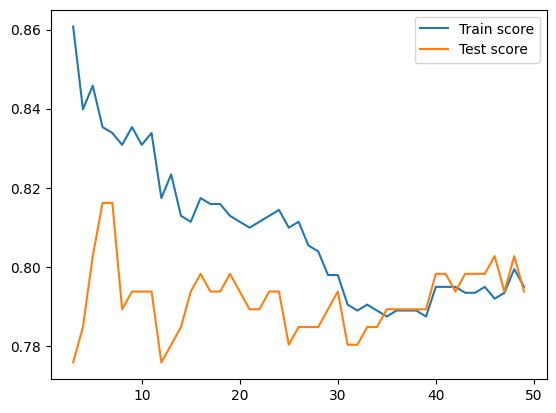

In [28]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = range(3, 50)
knc_scores = []

for k in n_neighbors:
    knc = KNeighborsClassifier(n_neighbors=k)
    knc.fit(X_train_scaled, y_train)
    knc_train = knc.score(X_train_scaled, y_train)
    knc_test = knc.score(X_test_scaled, y_test)
    knc_scores.append((k, knc_test, knc_train))

max_k, max_knc_test, max_knc_train = max(knc_scores, key=lambda x:x[1])

print(f'=== KNN Classifier(best k={max_k}) ===')
print('Train score:', max_knc_train)
print('Test score :', max_knc_test)

plt.plot(n_neighbors, [score[2] for score in knc_scores], label='Train score')
plt.plot(n_neighbors, [score[1] for score in knc_scores], label='Test score')
plt.legend()
plt.show()

## 로지스틱 회귀 분류

=== Logistic Regression(best C=0.01) ===
Train score: 0.7934131736526946
Test score : 0.7982062780269058


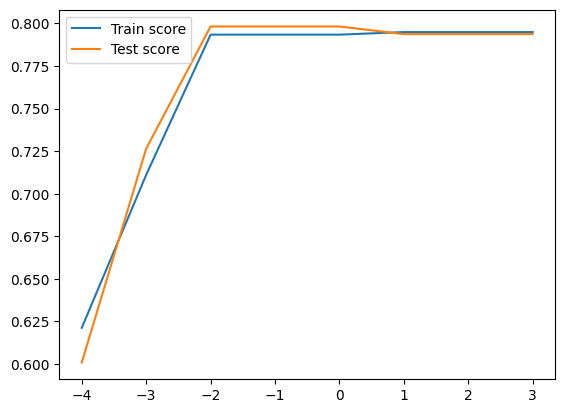

In [34]:
from sklearn.linear_model import LogisticRegression

C_list = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
lr_scores = []

for C in C_list:
    lr = LogisticRegression(C=C, max_iter=1000)
    lr.fit(X_train_scaled, y_train)
    lr_train = lr.score(X_train_scaled, y_train)
    lr_test = lr.score(X_test_scaled, y_test)
    lr_scores.append((C, lr_test, lr_train))

max_C, max_lr_test, max_lr_train = max(lr_scores, key=lambda x:x[1])

print(f'=== Logistic Regression(best C={max_C}) ===')
print('Train score:', max_lr_train)
print('Test score :', max_lr_test)

plt.plot(np.log10(C_list), [score[2] for score in lr_scores], label='Train score')
plt.plot(np.log10(C_list), [score[1] for score in lr_scores], label='Test score')
plt.legend()
plt.show()

## 결정 트리 분류

=== Decision Tree Classifier(best max_depth=7) ===
Train score: 0.8697604790419161
Test score : 0.820627802690583


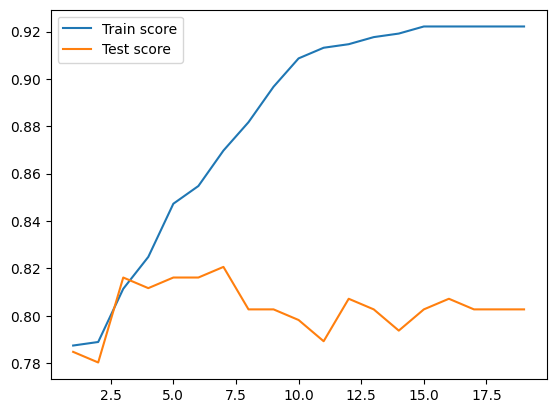

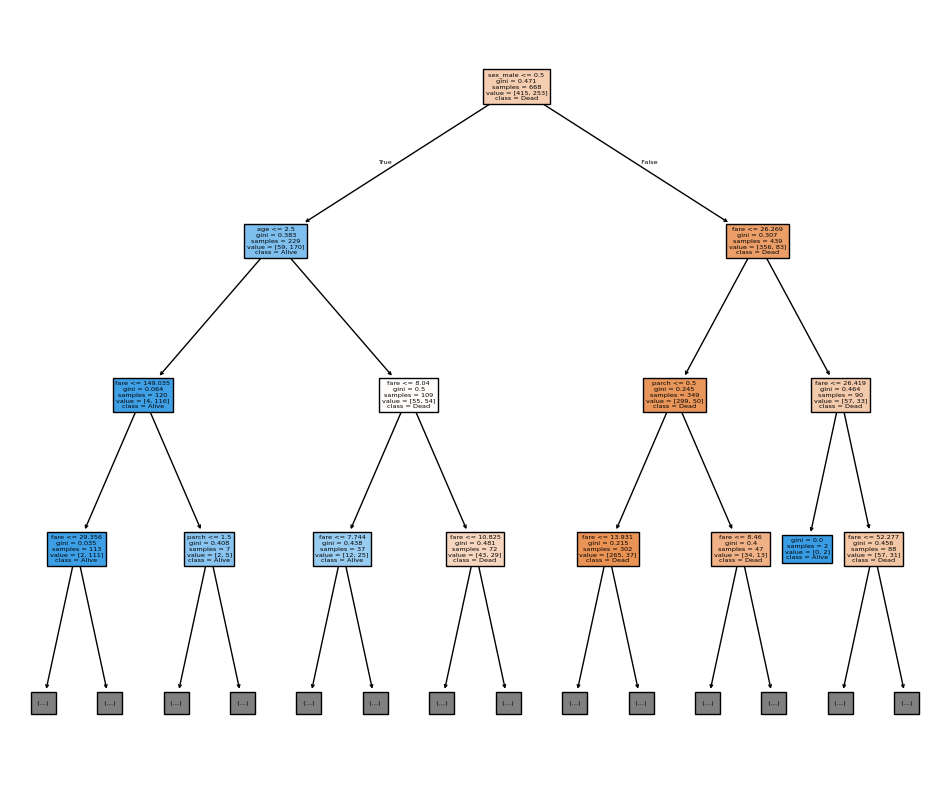

In [40]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

max_depths = range(1, 20)
dtc_scores = []

for max_depth in max_depths:
    dtc = DecisionTreeClassifier(random_state=42, max_depth=max_depth)
    dtc.fit(X_train, y_train)
    dtc_train = dtc.score(X_train, y_train)
    dtc_test = dtc.score(X_test, y_test)
    dtc_scores.append((max_depth, dtc_test, dtc_train))

max_max_depth, max_dtc_test, max_dtc_train = max(dtc_scores, key=lambda x:x[1])
print(f'=== Decision Tree Classifier(best max_depth={max_max_depth}) ===')
print(f'Train score: {max_dtc_train}')
print(f'Test score : {max_dtc_test}') 

plt.plot(max_depths, [score[2] for score in dtc_scores], label='Train score')
plt.plot(max_depths, [score[1] for score in dtc_scores], label='Test score')
plt.legend()
plt.show()

dtc = DecisionTreeClassifier(random_state=42, max_depth=max_max_depth)
dtc.fit(X_train, y_train)

plt.figure(figsize=(12,10))
plot_tree(dtc, filled=True, max_depth=3, class_names=['Dead', 'Alive'], feature_names=['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_female', 'sex_male'])
plt.show()

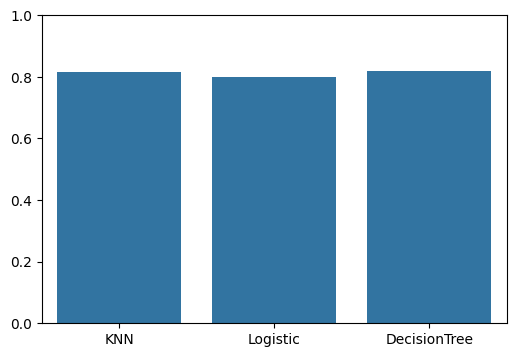

In [37]:
plt.figure(figsize=(6,4))
sns.barplot(x=['KNN', 'Logistic', 'DecisionTree'], y=[max_knc_test, max_lr_test, max_dtc_test])
plt.ylim(0, 1)
plt.show()